http://d2l.ai/chapter_optimization/lr-scheduler.html

In [3]:
!pip install d2l

  Using cached d2l-0.17.3-py3-none-any.whl (82 kB)
     |████████████████████████████████| 9.7 MB 6.8 MB/s            
     |████████████████████████████████| 11.6 MB 67.1 MB/s            
     |████████████████████████████████| 20.6 MB 47.0 MB/s            
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: pandas
    Found existing installation: pandas 1.2.5
    Uninstalling pandas-1.2.5:
      Successfully uninstalled pandas-1.2.5
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.0
    Uninstalling matplotlib-3.5.0:
      Successfully uninstalled matplotlib-3.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.6.2 requires numpy~=1.19.2, but you have numpy 1.18.5 which is incompatible.
tenso

In [1]:
%matplotlib inline
import math
import tensorflow as tf
from tensorflow.keras.callbacks import LearningRateScheduler
from d2l import tensorflow as d2l


def net():
    return tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(filters=6, kernel_size=5, activation='relu',
                               padding='same'),
        tf.keras.layers.AvgPool2D(pool_size=2, strides=2),
        tf.keras.layers.Conv2D(filters=16, kernel_size=5,
                               activation='relu'),
        tf.keras.layers.AvgPool2D(pool_size=2, strides=2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(120, activation='relu'),
        tf.keras.layers.Dense(84, activation='sigmoid'),
        tf.keras.layers.Dense(10)])


batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

# The code is almost identical to `d2l.train_ch6` defined in the
# lenet section of chapter convolutional neural networks
def train(net_fn, train_iter, test_iter, num_epochs, lr,
              device=d2l.try_gpu(), custom_callback = False):
    device_name = device._device_name
    strategy = tf.distribute.OneDeviceStrategy(device_name)
    with strategy.scope():
        optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        net = net_fn()
        net.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    callback = d2l.TrainCallback(net, train_iter, test_iter, num_epochs,
                             device_name)
    if custom_callback is False:
        net.fit(train_iter, epochs=num_epochs, verbose=0,
                callbacks=[callback])
    else:
         net.fit(train_iter, epochs=num_epochs, verbose=0,
                 callbacks=[callback, custom_callback])
    return net


### Sin scheduler

loss 0.214, train acc 0.921, test acc 0.890
68855.8 examples/sec on /GPU:0


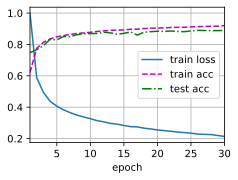

In [2]:
lr, num_epochs = 0.3, 30
train(net, train_iter, test_iter, num_epochs, lr)

### Definimos un scheduler que nos va a cambiar el lr dependiendo del num_update

In [3]:
class SquareRootScheduler:
    def __init__(self, lr=0.1):
        self.lr = lr

    def __call__(self, num_update):
        return self.lr * pow(num_update + 1.0, -0.5)

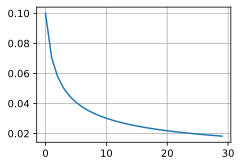

In [4]:
scheduler = SquareRootScheduler(lr=0.1)
d2l.plot(tf.range(num_epochs), [scheduler(t) for t in range(num_epochs)])

loss 0.382, train acc 0.860, test acc 0.850
76129.2 examples/sec on /GPU:0


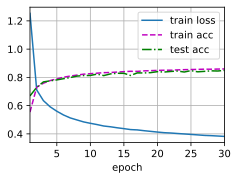

In [5]:
train(net, train_iter, test_iter, num_epochs, lr,
      custom_callback=LearningRateScheduler(scheduler))